# Working with audio is different

- Digital sounds measured in frequency (kHz)
- Frequency is the number of cycles per second
- Frequency (Hz) = (length of wave object array) / (duration of audio file in seconds)
- 1 kHz = 1000 pieces of information per second
- Small sample of audio = large amount of information
- You have to convert the audio to something useful

# Download the data from Kaggle

In [1]:
!pip install -q kaggle

In [2]:
%%bash

mkdir ~/.kaggle data

mv /content/kaggle.json ~/.kaggle/kaggle.json

kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

unzip -q z-by-hp-unlocked-challenge-3-signal-processing.zip -d data
rm z-by-hp-unlocked-challenge-3-signal-processing.zip

Dataset URL: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing
License(s): CC-BY-NC-SA-4.0



100%|██████████| 604M/604M [00:33<00:00, 19.0MB/s]


# Load the *.wav*  files

In [3]:
!pip install -q tensorflow==2.10.0 tensorflow-io==0.27.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 27.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requir

In [4]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from IPython.display import Audio, display

import warnings
warnings.filterwarnings('ignore')

In [5]:
capu_file = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC114131-2.wav')
not_capu_file = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'Crickets-chirping-0.wav')

In [6]:
def load_wav_16khz(filename):
    file_contents = tf.io.read_file(filename)

    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    wav = tf.squeeze(wav, axis=-1)

    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav

In [7]:
capu = load_wav_16khz(capu_file)
not_capu = load_wav_16khz(not_capu_file)

In [8]:
display(Audio(capu_file))

In [9]:
display(Audio(not_capu_file))

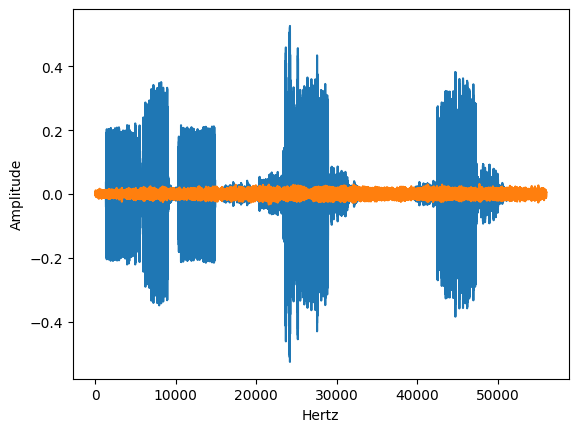

In [10]:
plt.plot(not_capu)
plt.plot(capu)
plt.xlabel('Hertz')
plt.ylabel('Amplitude')
plt.show()

# Create TF Dataset

In [11]:
from tensorflow.data import Dataset

In [12]:
pos = os.path.join('data', 'Parsed_Capuchinbird_Clips', '*.wav')
neg = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', '*.wav')

In [13]:
tf_data_pos = Dataset.list_files(pos)
tf_data_neg = Dataset.list_files(neg)

In [14]:
len(tf_data_pos), len(tf_data_neg)

(217, 593)

In [15]:
tf_data_pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC27882-5.wav'

In [16]:
pos_data = Dataset.zip((tf_data_pos, Dataset.from_tensor_slices(tf.ones(len(tf_data_pos)))))
neg_data = Dataset.zip((tf_data_neg, Dataset.from_tensor_slices(tf.zeros(len(tf_data_neg)))))
data = pos_data.concatenate(neg_data)
len(data)

810

In [17]:
pos_data.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC227468-3.wav', 1.0)

In [18]:
neg_data.as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-23.wav', 0.0)

# Determine the average length of the waves

In [20]:
num = 0
denum = 0

for wv_file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    num += len(load_wav_16khz(os.path.join('data', 'Parsed_Capuchinbird_Clips', wv_file)))
    denum += 1

num/denum

54156.66359447005

In [21]:
# Frequency (Hz) = (length of wave object array) / (duration of audio file in seconds)
print('The average bird call clips are:', 54156/16000, 'secs')

The average bird call clips are: 3.38475 secs


# Data Preparation

## Convert the data to Spectrogram

In [22]:
def create_spect(file, label):
    wave = load_wav_16khz(file)[:50000]
    wave = tf.concat([tf.zeros(50000-len(wave)), wave], 0)

    spect = tf.signal.stft(wave, frame_length=320, frame_step=32) # stft  --->  Sort Time Fourier Transform
    spect = tf.expand_dims(tf.abs(spect), axis=-1)

    return spect, label

In [23]:
sample = pos_data.shuffle(1000).as_numpy_iterator().next()
sp, lb = create_spect(*sample)
lb

1.0

In [24]:
sp.shape

TensorShape([1553, 257, 1])

In [25]:
tf.transpose(sp)[0].shape

TensorShape([257, 1553])

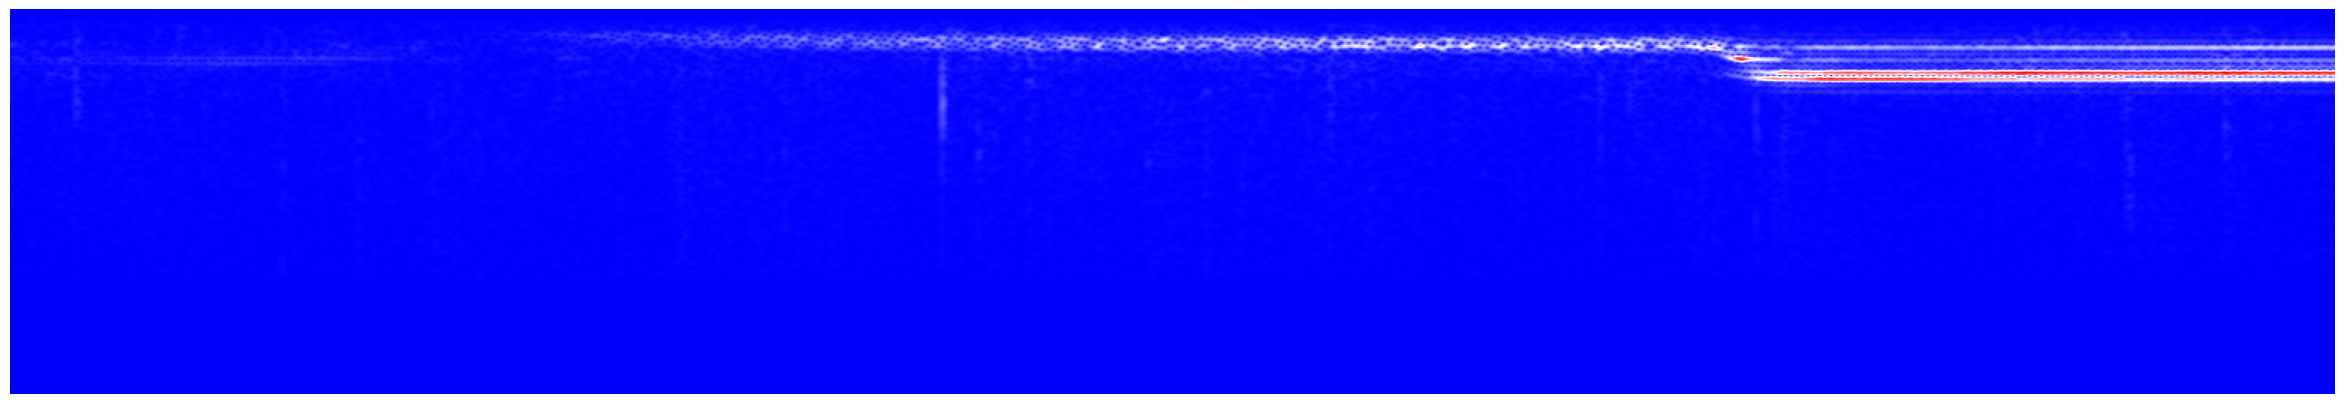

In [26]:
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(sp)[0], cmap='bwr')
plt.axis('off')
plt.show()

In [27]:
sample = neg_data.shuffle(1000).as_numpy_iterator().next()
sp, lb = create_spect(*sample)
lb

0.0

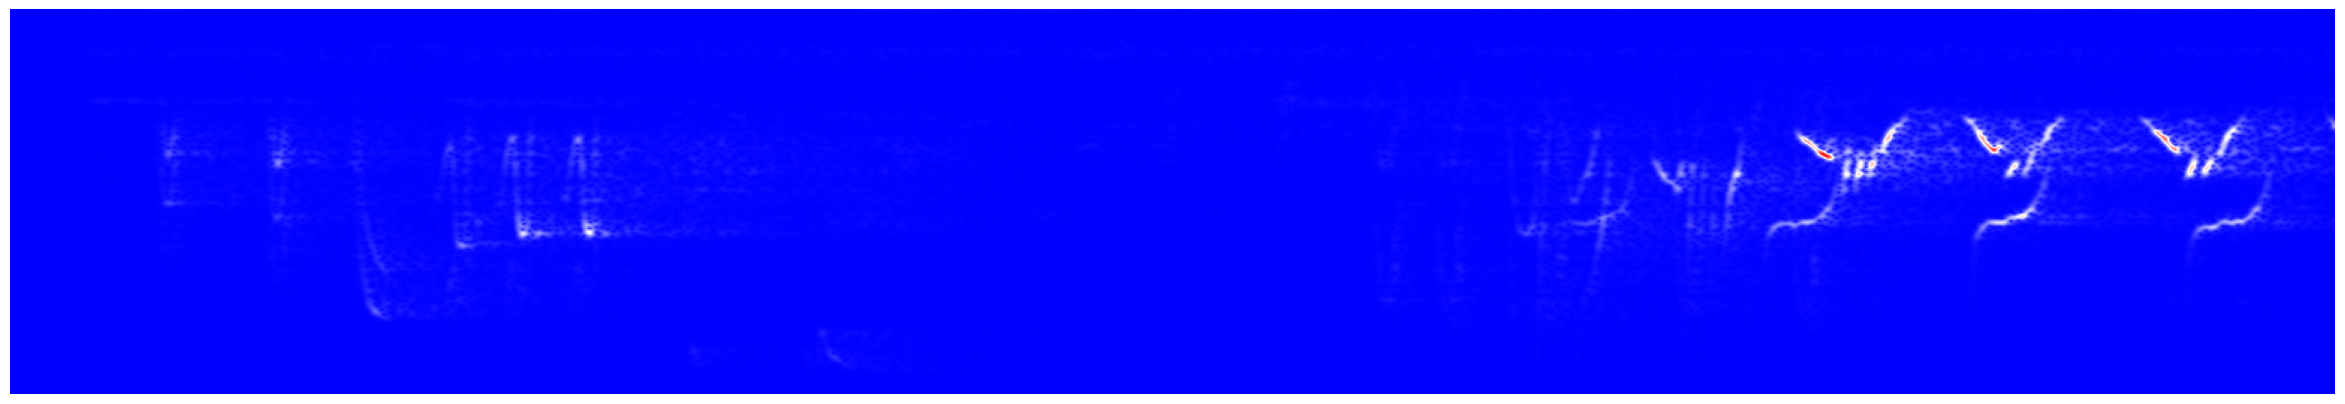

In [28]:
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(sp)[0], cmap='bwr')
plt.axis('off')
plt.show()

In [29]:
data = data.map(create_spect).cache().shuffle(buffer_size=1000).batch(16).prefetch(tf.data.AUTOTUNE)

## train test split

In [30]:
len(data)

51

In [31]:
len(data)*.7

35.699999999999996

In [32]:
len(data)*.3

15.299999999999999

In [33]:
train = data.take(36)
test = data.skip(36).take(15)

In [34]:
sample, labels = train.as_numpy_iterator().next()

In [35]:
sample.shape

(16, 1553, 257, 1)

In [36]:
labels

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

# Modeling

## Model Building

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.metrics import Recall, Precision

In [38]:
model = Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(1553, 257, 1)),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [39]:
model.compile(
    optimizer = 'adam',
    loss = 'BinaryCrossentropy',
    metrics = [Recall(), Precision()]
)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1551, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 775, 127, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1574800)           0         
                                                                 
 dense (Dense)               (None, 128)               201574528 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 201,574,817
Trainable params: 201,574,817
Non-trainable params: 0
__________________________________________

## Training

In [41]:
hist = model.fit(train, epochs = 4, validation_data = test)

Epoch 1/4
36/36 [==============================] - 166s 5s/step - loss: 6.8565 - recall: 0.9182 - precision: 0.7684 - val_loss: 0.7542 - val_recall: 0.9857 - val_precision: 0.8961
Epoch 2/4
36/36 [==============================] - 158s 4s/step - loss: 1.0050 - recall: 0.9679 - precision: 0.9742 - val_loss: 0.4909 - val_recall: 1.0000 - val_precision: 0.9254
Epoch 3/4
36/36 [==============================] - 163s 5s/step - loss: 0.3143 - recall: 0.9735 - precision: 0.9866 - val_loss: 0.3235 - val_recall: 0.9846 - val_precision: 0.7901
Epoch 4/4
36/36 [==============================] - 161s 4s/step - loss: 0.2086 - recall: 0.9934 - precision: 0.9438 - val_loss: 0.0014 - val_recall: 1.0000 - val_precision: 1.0000


# Plot the metrics

In [42]:
hist.history

{'loss': [6.856500625610352,
  1.0049612522125244,
  0.3143027424812317,
  0.20862910151481628],
 'recall': [0.9182389974594116,
  0.9679487347602844,
  0.9735099077224731,
  0.9934210777282715],
 'precision': [0.7684210538864136,
  0.9741935729980469,
  0.9865771532058716,
  0.9437500238418579],
 'val_loss': [0.7542262673377991,
  0.4908929765224457,
  0.3234768509864807,
  0.0013836012221872807],
 'val_recall': [0.9857142567634583, 1.0, 0.9846153855323792, 1.0],
 'val_precision': [0.8961039185523987,
  0.9253731369972229,
  0.790123462677002,
  1.0]}

In [43]:
hist.history.keys()

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])

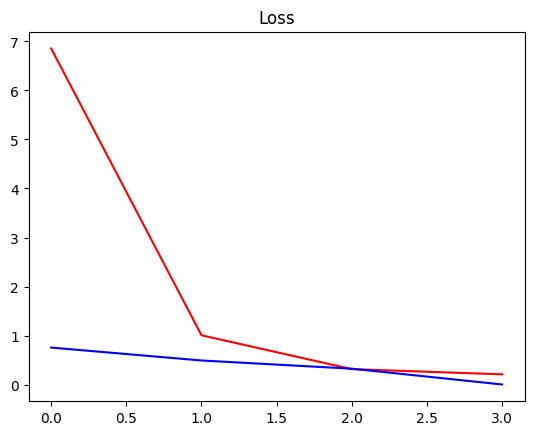

In [44]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

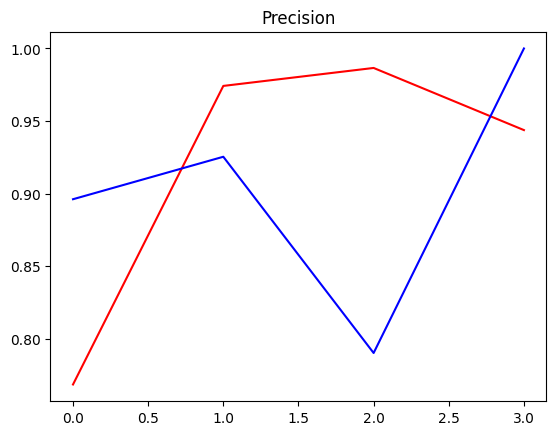

In [45]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

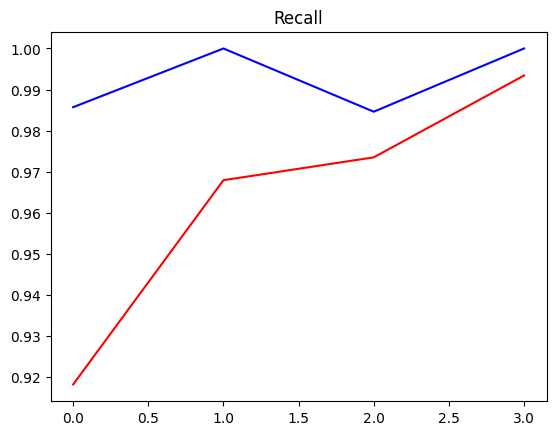

In [46]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# Prediction

In [47]:
import numpy as np

In [48]:
sample, labels = test.as_numpy_iterator().next()

In [49]:
sample.shape

(16, 1553, 257, 1)

In [50]:
labels

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [51]:
y_pred = model.predict(sample)

1/1 [==============================] - 2s 2s/step


In [52]:
y_pred

array([[4.1387208e-02],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [7.0533152e-32],
       [0.0000000e+00],
       [7.1121140e-30],
       [1.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [53]:
y_pred = (y_pred>0.5).astype('int').squeeze()
y_pred

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [54]:
labels = labels.astype(int)
labels

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [55]:
print('Accuracy:', sum(labels == y_pred)/len(labels), '%')

Accuracy: 1.0 %


# How many bird calls in Forest Data

## load *mp3* files

In [56]:
def load_mp3_16khz(filename):
    audio_tensor = tfio.audio.AudioIOTensor(filename)
    tensor = audio_tensor.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1)/2

    sample_rate = audio_tensor.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)


    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)

    return wav

In [57]:
forest_file = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')
forest_file

'data/Forest Recordings/recording_00.mp3'

In [58]:
forest = load_mp3_16khz(forest_file)
forest.shape

TensorShape([2880666])

In [59]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    data=forest, targets=forest, sequence_length=50000, sequence_stride=50000, batch_size=1
)

len(audio_slices)

57

In [60]:
sample, index = audio_slices.as_numpy_iterator().next()
sample.shape

(1, 50000)

In [61]:
index

array([8.143327e-12], dtype=float32)

## Create Spectrogram

In [62]:
def create_spect_mp3(sample, index):
    wave = sample[0]
    wave = tf.concat([tf.zeros(50000-len(wave)), wave], 0)

    spect = tf.signal.stft(wave, frame_length=320, frame_step=32) # stft  --->  Sort Time Fourier Transform
    spect = tf.expand_dims(tf.abs(spect), axis=-1)

    return spect

In [63]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    forest, forest, sequence_length=50000, sequence_stride=50000, batch_size=1
)

audio_slices = audio_slices.map(create_spect_mp3).batch(64)

## Make predictions on a single clip

In [64]:
from itertools import groupby

In [65]:
y_preds = model.predict(audio_slices)
y_preds.shape

1/1 [==============================] - 4s 4s/step


(57, 1)

In [66]:
y_preds = y_preds.squeeze()
y_preds.shape

(57,)

In [67]:
y_preds = (y_preds>0.96).astype(int)
y_preds

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [68]:
y_preds_grouped = [k for k, _ in groupby(y_preds)]
y_preds_grouped

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [69]:
display(Audio(forest_file))

## Make predictions

In [70]:
from tqdm import tqdm

In [71]:
def predict_on_file(filename):
    wav = load_mp3_16khz(filename)

    audio_slices = tf.keras.utils.timeseries_dataset_from_array(
        wav, wav, sequence_length=50000, sequence_stride=50000, batch_size=1
    )

    audio_slices = audio_slices.map(create_spect_mp3).batch(64)

    y_pred = model.predict(audio_slices, verbose=0)

    return y_pred

In [72]:
forest_preds = {}

for file in tqdm(os.listdir(os.path.join('data', 'Forest Recordings'))):
    file_path = os.path.join('data','Forest Recordings', file)

    y_pred = predict_on_file(file_path)
    y_pred = (y_pred>0.96).astype(int)

    forest_preds[file] = sum([k for k, _ in groupby(y_pred)])[0]


100%|██████████| 100/100 [08:35<00:00,  5.16s/it]


In [73]:
len(forest_preds.keys())

100

# Export the results to CSV file

In [74]:
import csv

In [75]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in forest_preds.items():
        writer.writerow([key, value])

In [76]:
forest_preds

{'recording_50.mp3': 0,
 'recording_76.mp3': 0,
 'recording_07.mp3': 2,
 'recording_39.mp3': 6,
 'recording_83.mp3': 0,
 'recording_54.mp3': 3,
 'recording_15.mp3': 2,
 'recording_68.mp3': 1,
 'recording_49.mp3': 0,
 'recording_73.mp3': 0,
 'recording_74.mp3': 0,
 'recording_48.mp3': 10,
 'recording_32.mp3': 2,
 'recording_98.mp3': 22,
 'recording_29.mp3': 0,
 'recording_99.mp3': 5,
 'recording_91.mp3': 1,
 'recording_22.mp3': 2,
 'recording_33.mp3': 0,
 'recording_78.mp3': 7,
 'recording_46.mp3': 12,
 'recording_17.mp3': 14,
 'recording_96.mp3': 1,
 'recording_25.mp3': 14,
 'recording_55.mp3': 0,
 'recording_94.mp3': 2,
 'recording_04.mp3': 10,
 'recording_44.mp3': 1,
 'recording_59.mp3': 14,
 'recording_58.mp3': 0,
 'recording_84.mp3': 12,
 'recording_10.mp3': 5,
 'recording_85.mp3': 0,
 'recording_57.mp3': 4,
 'recording_51.mp3': 4,
 'recording_52.mp3': 0,
 'recording_71.mp3': 15,
 'recording_92.mp3': 11,
 'recording_53.mp3': 0,
 'recording_24.mp3': 0,
 'recording_62.mp3': 0,
 'reco